# Customer Transaction Analysis

This notebook processes retail data obtained from [Kaggle](https://www.kaggle.com/datasets/aslanahmedov/market-basket-analysis) and performs analytics on customer transactions to achieve the following objectives:

1. **Cluster and identify customer groups**: Utilize clustering techniques to segment customers into distinct groups, allowing for the design and implementation of targeted marketing campaigns.
2. **Collaborative filtering for recommendations**: Implement collaborative filtering algorithms to suggest items to customers based on the preferences of similar customers, thus enhancing the shopping experience and increasing sales.
3. **Frequent itemset mining**: Analyze pairs of items that frequently occur together in customer baskets to optimize store layout and inform effective cross-selling strategies.

The analysis is divided into three sections, each accompanied by detailed explanations of the code cells and conclusions drawn from the results.


## Import and Read Data

In [1]:
import polars as pl
import datetime as dt
from functools import reduce
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import plotly.express as px
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import pairwise_distances
from itertools import combinations

This code snippet demonstrates how to read and clean a CSV file using the Polars library in Python:

1. **Read CSV file**: The `pl.read_csv()` function reads the CSV file, "data/retaildata.csv", and infers the schema from the data.
2. **Filter out 'Adjust bad debt'**: The `.filter()` method removes any rows where the 'Itemname' column has the value 'Adjust bad debt'.
3. **Cast columns to correct data types**: The `.with_columns()` method is used to cast the 'BillNo', 'Itemname', 'Quantity', 'Date', 'Price', 'CustomerID', and 'Country' columns to the appropriate data types, such as `pl.Int32`, `pl.Utf8`, `pl.Datetime`, and `pl.Float32`.
4. **Parse date string**: The 'Date' column is parsed from the date string format using `.str.strptime()` method.
5. **Remove rows with null values**: The `.drop_nulls()` method is used to remove any rows that contain null values.

After executing the code, a cleaned Polars DataFrame named `df` is created.


In [2]:


#Read, remove bad debt adjustment and cast columns to correct types
df = (pl.read_csv("data/retaildata.csv", infer_schema_length=0)
      .filter(pl.col("Itemname")!='Adjust bad debt')
      .with_columns(pl.col('BillNo').cast(pl.Int32))
        .with_columns(pl.col('Itemname').cast(pl.Utf8))
        .with_columns(pl.col('Quantity').cast(pl.Int32))
        .with_columns(pl.col('Date').str.strptime(pl.Datetime,fmt='%d/%m/%Y %H:%M'))
        .with_columns(pl.col('Price').cast(pl.Float32))
        .with_columns(pl.col('CustomerID').cast(pl.Int32))
        .with_columns(pl.col('Country').cast(pl.Utf8))
        .drop_nulls()
)




## Cluster and identify customer groups

This code snippet demonstrates how to calculate Recency, Frequency, and Monetary (RFM) values for customers in a Polars DataFrame named `df`:

1. **Calculate 'today'**: The `today` variable is calculated by getting the maximum 'Date' from the DataFrame, and adding one day to it using the `datetime.timedelta` function.
2. **Calculate Recency**: A new DataFrame `df_Recency` is created by grouping `df` by 'CustomerID' and calculating the difference between `today` and the maximum 'Date' for each group, which is then aliased as 'Recency'.
3. **Calculate Frequency**: A new DataFrame `df_Frequencuy` is created by grouping `df` by 'CustomerID' and counting the unique 'BillNo' occurrences for each group, which is then aliased as 'Frequency'.
4. **Calculate Monetary**: A new DataFrame `df_Monetary` is created by grouping `df` by 'CustomerID' and summing the 'Price' for each group, which is then aliased as 'Monetary'.
5. **Merge DataFrames**: A list `dfs` is created containing the three DataFrames: `df_Recency`, `df_Frequencuy`, and `df_Monetary`. The `reduce()` function is then used to join these DataFrames on the 'CustomerID' column, resulting in a new DataFrame `df_RFM`.
6. **Display the first 5 rows**: The `.head(5)` method is used to display the first 5 rows of the `df_RFM` DataFrame.

After executing the code, a new DataFrame `df_RFM` is created containing the Recency, Frequency, and Monetary values for each customer.


In [3]:
today = df.select('Date').max().item() + dt.timedelta(days=1)
df_Recency = df.groupby('CustomerID').agg((today-pl.col('Date').max()).alias('Recency'))
df_Frequencuy = df.groupby('CustomerID').agg(pl.col('BillNo').unique().count().alias('Frequency'))
df_Monetary = df.groupby('CustomerID').agg(pl.col('Price').sum().alias('Monetary'))
dfs = [df_Recency, df_Frequencuy, df_Monetary]
df_RFM = reduce(lambda left,right: left.join(right, on='CustomerID'), dfs)
df_RFM.head(5)

CustomerID,Recency,Frequency,Monetary
i32,duration[μs],u32,f32
14608,4d 19h 58m,4,84.499992
15840,59d 3h 42m,2,52.950008
14240,30d 23h 5m,2,144.469971
14080,33d 1h 41m,1,3.8
16000,3d 33m,3,30.110001


This code snippet demonstrates how to use the KMeans clustering algorithm from the `sklearn` library to find the optimal number of clusters for the RFM DataFrame `df_RFM`:

1. **Import required libraries**: Import the `StandardScaler` from `sklearn.preprocessing` and `KMeans` from `sklearn.cluster`.
2. **Scale RFM data**: Create a `StandardScaler` object and fit_transform the `df_RFM` DataFrame to create a scaled version, `rfm_scaled`.
3. **Initialize list to store inertia values**: Create an empty list named `inertia` to store the inertia values for different numbers of clusters.
4. **Calculate inertia for different numbers of clusters**: Iterate from 1 to 19, and for each value:
   - Create a `KMeans` object with the current number of clusters and a fixed random state of 42.
   - Fit the `KMeans` object on the `rfm_scaled` data.
   - Append the inertia value of the current KMeans model to the `inertia` list.
5. **Plot inertia and inertia differences**: Use the `matplotlib.pyplot` library to create a plot showing the inertia values and their differences for different numbers of clusters.
   - Set the figure size to (12,8).
   - Plot the inertia values and their differences with markers.
   - Set the plot title, x-axis label, and y-axis label.
   - Add a legend for the two plotted lines: "Inertia" and "Inertia Diff".

After executing the code, a plot is displayed showing the inertia values and their differences for different numbers of clusters, which helps to identify the optimal number of clusters using the Elbow method. The Elbow Method helps us find a balance between minimizing the inertia value and avoiding overfitting by not choosing an excessively large number of clusters. This approach helps us to strike a balance between model complexity and the accuracy of the clustering results. Five was chosen as the optimal number of clusters in this case because, after this point, we observed the inertia decreasing at a slower rate. This indicates that the additional benefit of increasing the number of clusters beyond five starts to diminish, and the elbow point occurs at k=5.


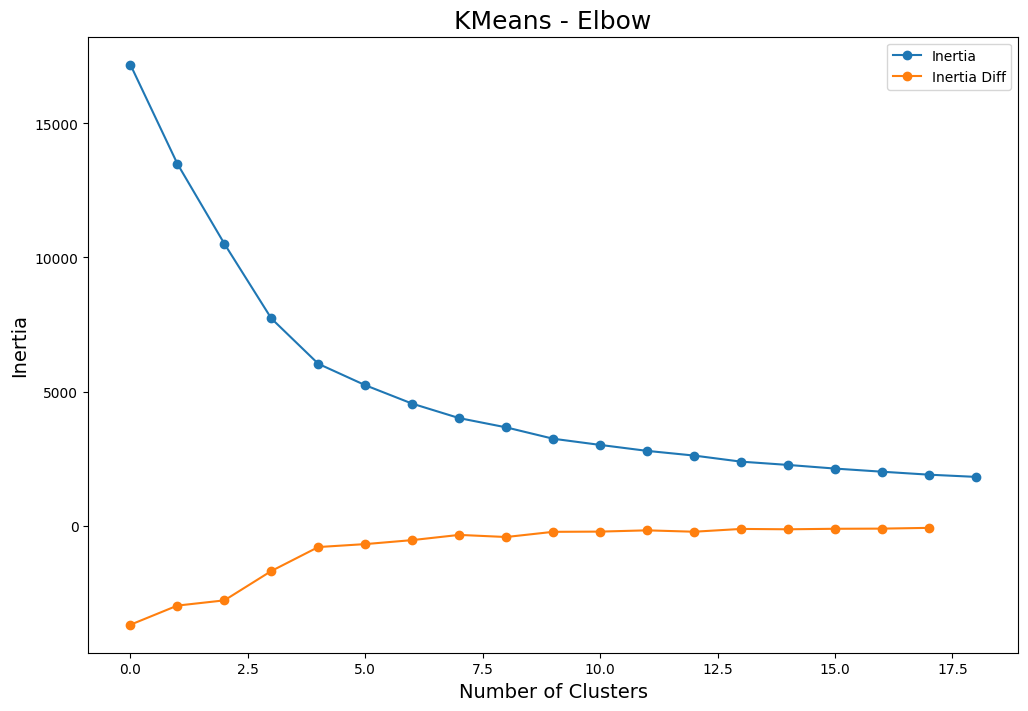

In [4]:
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(df_RFM)
inertia = []

for i in np.arange(1,20):
    kmeans = KMeans(n_clusters = i, random_state = 42)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize = (12,8))    
plt.plot(inertia, marker = "o")
plt.plot(np.diff(inertia), marker = "o")
plt.title("KMeans - Elbow", fontsize = 18)
plt.xlabel("Number of Clusters", fontsize = 14)
plt.ylabel("Inertia", fontsize = 14)
plt.legend(["Inertia", "Inertia Diff"]);

This code snippet demonstrates how to fit a KMeans clustering model with 5 clusters on the scaled RFM data and visualize the clusters using a 3D scatter plot:

1. **Fit KMeans model with 5 clusters**: Create a `KMeans` object with 5 clusters and a fixed random state of 42, then fit the model on the `rfm_scaled` data.
2. **Assign cluster labels to the original DataFrame**: Add a new column named "Cluster No" to the `df_RFM` DataFrame containing the cluster labels determined by the KMeans model, incremented by 1 to start counting clusters from 1 instead of 0.
3. **Create a 3D scatter plot**: Use the `plotly.express.scatter_3d` function to create a 3D scatter plot of the RFM data, with the following settings:
   - Convert the Polars DataFrame `df_RFM` to a Pandas DataFrame.
   - Set the x-axis to 'Cluster No'.
   - Set the y-axis to 'Frequency'.
   - Set the z-axis to 'Recency'.
   - Set the size of the markers to 'Monetary'.
   - Set the color of the markers to 'Cluster No'.
   - Set the plot title to 'Clusters'.

After executing the code, a 3D scatter plot is displayed, visualizing the 5 clusters of customers based on their RFM values.


In [5]:
kmeans = KMeans(n_clusters = 5, random_state = 42)
kmeans.fit(rfm_scaled)
df_RFM = df_RFM.with_columns(pl.Series(name="Cluster No", values=(kmeans.labels_ + 1))) 
df_RFM.head(5)

CustomerID,Recency,Frequency,Monetary,Cluster No
i32,duration[μs],u32,f32,i32
14608,4d 19h 58m,4,84.499992,1
15840,59d 3h 42m,2,52.950008,4
14240,30d 23h 5m,2,144.469971,1
14080,33d 1h 41m,1,3.8,1
16000,3d 33m,3,30.110001,4


In [6]:
#This can be used for interactive plots
px.scatter_3d(df_RFM.to_pandas(), 
              x='Cluster No', 
              y='Frequency', 
              z='Recency',
              size='Monetary',
              
              color='Cluster No', title='Clusters')


## Conclusions
See [Cluster.png](Cluster.png)

- **Cluster Group 5**: This small group of three customers spent significantly more than the average customer, with two of them visiting the store more frequently. We could target these high-value customers as brand ambassadors to help grow the community and promote our brand.

- **Cluster Groups 4 and 1**: These customers have relatively low spending, infrequent visits, and recent activity. They could potentially be new customers. Implementing a new customer campaign that offers discounts and incentives for these groups could encourage them to become loyal customers.

- **Cluster 3**: Customers in this group tend to spend more and visit more frequently, suggesting that they are likely local, loyal customers. Targeting this group with a loyalty reward campaign can help maintain their engagement and enhance customer retention.

- **Cluster 2**: Customers in this group have not visited the store for a long time and exhibited low spending during their infrequent visits. It appears that these customers may have stopped using the store for some reason. A targeted "return reward" campaign could entice them to revisit and re-engage with the store.


# Collaborative Filtering Recommendations

This code snippet demonstrates how to create a new DataFrame `df_cust` that contains the total number of times each customer had each item in their basket in the original `df` DataFrame:

1. **Select 'CustomerID' and 'Itemname' columns**: Use the `.select()` method on the `df` DataFrame to select only the 'CustomerID' and 'Itemname' columns.
2. **Convert 'Itemname' to dummy variables**: Use the `.to_dummies()` method on the selected DataFrame to convert the 'Itemname' column into dummy variables. Each unique item in the 'Itemname' column will be transformed into a new column with a binary value, indicating whether the item was in the basket (1) or not (0) in the respective row.
3. **Group by 'CustomerID' and sum**: Use the `.groupby()` method on the DataFrame with dummy variables to group the data by 'CustomerID', and then apply the `.sum()` method to get the total number of times each item was in the basket for each customer.
4. **Display the first 5 rows**: Use the `.head()` method to display the first 5 rows of the resulting `df_cust` DataFrame.

After executing the code, a new DataFrame `df_cust` is created, containing the total number of times each item was in the basket for each customer. This is a customer profile.


In [7]:
#User base collerative filtering
#create customer-item matrix i.e profile matrix df_cust
df_cust = (df.select(['CustomerID','Itemname'])
            .to_dummies(columns=['Itemname'])
            .groupby('CustomerID').sum()
            )
           
df_cust.head()


CustomerID,Itemname_10 COLOUR SPACEBOY PEN,Itemname_12 COLOURED PARTY BALLOONS,Itemname_12 DAISY PEGS IN WOOD BOX,Itemname_12 EGG HOUSE PAINTED WOOD,Itemname_12 HANGING EGGS HAND PAINTED,Itemname_12 IVORY ROSE PEG PLACE SETTINGS,Itemname_12 MESSAGE CARDS WITH ENVELOPES,Itemname_12 PENCIL SMALL TUBE WOODLAND,Itemname_12 PENCILS SMALL TUBE RED RETROSPOT,Itemname_12 PENCILS SMALL TUBE SKULL,Itemname_12 PENCILS TALL TUBE POSY,Itemname_12 PENCILS TALL TUBE RED RETROSPOT,Itemname_12 PENCILS TALL TUBE SKULLS,Itemname_12 PENCILS TALL TUBE WOODLAND,Itemname_12 PINK HEN+CHICKS IN BASKET,Itemname_12 PINK ROSE PEG PLACE SETTINGS,Itemname_12 RED ROSE PEG PLACE SETTINGS,Itemname_15 PINK FLUFFY CHICKS IN BOX,Itemname_15CM CHRISTMAS GLASS BALL 20 LIGHTS,Itemname_16 PC CUTLERY SET PANTRY DESIGN,Itemname_16 PIECE CUTLERY SET PANTRY DESIGN,Itemname_18PC WOODEN CUTLERY SET DISPOSABLE,Itemname_2 PICTURE BOOK EGGS EASTER BUNNY,Itemname_2 PICTURE BOOK EGGS EASTER CHICKS,Itemname_2 PICTURE BOOK EGGS EASTER DUCKS,Itemname_20 DOLLY PEGS RETROSPOT,Itemname_200 BENDY SKULL STRAWS,Itemname_200 RED + WHITE BENDY STRAWS,Itemname_3 BIRDS CANVAS SCREEN,Itemname_3 BLACK CATS W HEARTS BLANK CARD,Itemname_3 DRAWER ANTIQUE WHITE WOOD CABINET,Itemname_3 GARDENIA MORRIS BOXED CANDLES,Itemname_3 HEARTS HANGING DECORATION RUSTIC,Itemname_3 HOOK HANGER MAGIC GARDEN,Itemname_3 HOOK PHOTO SHELF ANTIQUE WHITE,Itemname_3 PIECE SPACEBOY COOKIE CUTTER SET,…,Itemname_YELLOW FLOWERS FELT HANDBAG KIT,Itemname_YELLOW GIANT GARDEN THERMOMETER,Itemname_YELLOW METAL CHICKEN HEART,Itemname_YELLOW PINK FLOWER DESIGN BIG BOWL,Itemname_YELLOW POT PLANT CANDLE,Itemname_YELLOW SHARK HELICOPTER,Itemname_YELLOW/BLUE RETRO RADIO,Itemname_YELLOW/ORANGE FLOWER DESIGN PLATE,Itemname_YELLOW/PINK FLOWER DESIGN BIG MUG,Itemname_YOU'RE CONFUSING ME METAL SIGN,Itemname_YULETIDE IMAGES GIFT WRAP SET,Itemname_YULETIDE IMAGES S/6 PAPER BOXES,Itemname_ZINC HEART T-LIGHT HOLDER,Itemname_ZINC STAR T-LIGHT HOLDER,Itemname_ZINC BOX SIGN HOME,Itemname_ZINC FINISH 15CM PLANTER POTS,Itemname_ZINC FOLKART SLEIGH BELLS,Itemname_ZINC HEART FLOWER T-LIGHT HOLDER,Itemname_ZINC HEART LATTICE 2 WALL PLANTER,Itemname_ZINC HEART LATTICE CHARGER LARGE,Itemname_ZINC HEART LATTICE CHARGER SMALL,Itemname_ZINC HEART LATTICE T-LIGHT HOLDER,Itemname_ZINC HEART LATTICE TRAY OVAL,Itemname_ZINC HEARTS PLANT POT HOLDER,Itemname_ZINC HERB GARDEN CONTAINER,Itemname_ZINC METAL HEART DECORATION,Itemname_ZINC PLANT POT HOLDER,Itemname_ZINC STAR T-LIGHT HOLDER,Itemname_ZINC SWEETHEART SOAP DISH,Itemname_ZINC SWEETHEART WIRE LETTER RACK,Itemname_ZINC T-LIGHT HOLDER STAR LARGE,Itemname_ZINC T-LIGHT HOLDER STARS LARGE,Itemname_ZINC T-LIGHT HOLDER STARS SMALL,Itemname_ZINC TOP 2 DOOR WOODEN SHELF,Itemname_ZINC WILLIE WINKIE CANDLE STICK,Itemname_ZINC WIRE KITCHEN ORGANISER,Itemname_ZINC WIRE SWEETHEART LETTER TRAY
i32,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,…,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
18272,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
17696,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
14768,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
17248,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12720,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


This code snippet demonstrates how to calculate the pairwise distances between customers based on their item purchase history and create a distance matrix using Pandas:

1. **Convert Polars DataFrame to Pandas DataFrame**: Use the `.to_pandas()` method to convert the `df_cust` DataFrame (containing the total number of times each item was in the basket for each customer) to a Pandas DataFrame, `df_cust_pd`.
2. **Calculate pairwise distances**: Use the `pairwise_distances` function from `sklearn.metrics` to calculate the pairwise distances between customers based on their item purchase history. Store the result in the `dist` variable.
3. **Create a distance matrix**: Create a new Pandas DataFrame `df_dist` using the pairwise distances stored in the `dist` variable, with the index and columns set to the 'CustomerID' values from `df_cust_pd`.
4. **Display the first 10 rows**: Use the `.head(10)` method to display the first 10 rows of the `df_dist` DataFrame.

After executing the code, a new DataFrame `df_dist` is created, containing the pairwise distances between customers based on their item purchase history.


In [8]:
#calculate pairwise distance and create distance matrix df_dist
df_cust_pd = df_cust.to_pandas()
dist = pairwise_distances(df_cust_pd)
df_dist = pd.DataFrame(dist, index=df_cust_pd.CustomerID, columns=df_cust_pd.CustomerID)
df_dist.head(10)


CustomerID,18272,17696,14768,17248,12720,13008,14128,14800,16096,14240,...,15713,14385,16513,16817,18113,16497,15953,17969,15089,17841
CustomerID,,,,,,,,,,,,,,,,,,,,,
18272,0.000000,576.502385,3504.054651,1024.213357,5552.091138,5264.035714,4144.052365,3472.165751,2176.089153,4032.051835,...,2559.077177,3887.050424,1759.104318,1455.160129,160.181147,1775.144783,2319.131950,303.642882,3183.074300,550.501589
17696,576.502385,0.000000,2928.036885,448.299007,4976.107816,4688.023784,3568.034053,2896.167122,1600.069061,3456.036892,...,1983.057992,3311.033675,1183.104814,879.181437,417.251723,1199.138024,1743.120765,273.408120,2607.067893,372.680829
14768,3504.054651,2928.036885,0.000000,2480.015726,2048.220447,1760.005966,640.050779,42.661458,1328.007154,528.053975,...,945.014815,383.030025,1745.010888,2049.029526,3345.001196,1729.045980,1185.104215,3201.003280,321.239786,3092.275699
17248,1024.213357,448.299007,2480.015726,0.000000,4528.099712,4240.010024,3120.020352,2448.174830,1152.036024,3008.020113,...,1535.029316,2863.014495,735.074826,431.214564,865.041617,751.144460,1295.116211,721.057557,2159.050023,685.415932
12720,5552.091138,4976.107816,2048.220447,4528.099712,0.000000,289.547923,1408.338028,2080.381936,3376.134772,1520.307206,...,2993.153187,1665.270248,3793.121933,4097.117645,5393.083348,3777.137408,3233.175065,5249.086873,2369.203664,5132.321502
13008,5264.035714,4688.023784,1760.005966,4240.010024,289.547923,0.000000,1120.030357,1792.221805,3088.004210,1232.025974,...,2705.006469,1377.010893,3505.007275,3809.017065,5105.001469,3489.023789,2945.042445,4961.002822,2081.040605,4845.261603
14128,4144.052365,3568.034053,640.050779,3120.020352,1408.338028,1120.030357,0.000000,672.628426,1968.017784,112.427755,...,1585.024290,257.143929,2385.020755,2689.031610,3985.007403,2369.041367,1825.075067,3841.009112,961.108735,3728.901715
14800,3472.165751,2896.167122,42.661458,2448.174830,2080.381936,1792.221805,672.628426,0.000000,1296.311305,560.752173,...,913.446769,415.959133,1713.236411,2017.210450,3313.120432,1697.268394,1153.441806,3169.126378,290.566688,3060.031209
16096,2176.089153,1600.069061,1328.007154,1152.036024,3376.134772,3088.004210,1968.017784,1296.311305,0.000000,1856.016164,...,383.040468,1711.008182,417.063544,721.088760,2017.003223,401.204437,143.878421,1873.006941,1007.083909,1778.660170


This code snippet defines two functions to help you find the top items that a customer might like based on the items that other similar customers have bought:

1. **`find_differences()`**: This function compares two rows in a DataFrame and returns column names with differences.
   - Input: `df` (DataFrame), `id1` (first CustomerID), and `id2` (second CustomerID).
   - Process:
     - Get the rows corresponding to the two CustomerIDs (excluding the 'CustomerID' column) and reset their index.
     - Find the differences between the two rows and store the result in a boolean Series named `differences`.
   - Output: Return a list of column names where the rows have differences.

2. **`find_items_they_might_like()`**: This function finds the top items that a customer might like based on the items that other similar customers have bought.
   - Input: `df` (DataFrame) and `target_cust` (target CustomerID).
   - Process:
     - Initialize an empty list named `items_they_might_like` to store the items that the target customer might like.
     - Find the 20 most similar customers to the target customer in the `df_dist` DataFrame, excluding the target customer (using `.nsmallest(20)[1:]`).
     - For each similar customer, find the differences in items purchased between the target customer and the similar customer using the `find_differences()` function. Extend the `items_they_might_like` list with the found differences.
   - Output: Return the `items_they_might_like` list.

After defining these functions, you can use them to find the top items that a customer might like based on the items that other similar customers have bought.


In [9]:
# Function to compare two rows and return column names with differences
def find_differences(df, id1, id2):
    row1 = df[df['CustomerID'] == id1].drop('CustomerID', axis=1).reset_index(drop=True)
    row2 = df[df['CustomerID'] == id2].drop('CustomerID', axis=1).reset_index(drop=True)
    differences = (row1 != row2).any()

    return differences.index[differences].tolist()

#A function to find the top 10 items that a customer might like 
# based on the items that other customers who are similar to them have bought
def find_items_they_might_like(df, target_cust):
    items_they_might_like = []
    for cust_id in df_dist[target_cust].nsmallest(20)[1:].index:
        items_they_might_like.extend(find_differences(df_cust_pd, target_cust, cust_id))
    return items_they_might_like

In [10]:
#Find the top 10 items that customer 14368 might like
target_cust = 14368
pd.Series(find_items_they_might_like(df_cust_pd,target_cust)).value_counts().head(10)

Itemname_AIRLINE BAG VINTAGE WORLD CHAMPION    19
Itemname_DOG BOWL CHASING BALL DESIGN          19
Itemname_MIRRORED DISCO BALL                   19
Itemname_PAINT YOUR OWN CANVAS SET             19
Itemname_AIRLINE BAG VINTAGE JET SET RED       18
Itemname_WOODEN CROQUET GARDEN SET             18
Itemname_AIRLINE BAG VINTAGE TOKYO 78          18
Itemname_WOODEN ROUNDERS GARDEN SET            18
Itemname_ROSES REGENCY TEACUP AND SAUCER        5
Itemname_REGENCY CAKESTAND 3 TIER               5
dtype: int64

## Conclusions

The implemented Collaborative Filtering algorithm in this notebook demonstrates a method to recommend items to customers based on the purchase history of similar customers. In essence, this model suggests items to customers by taking into account the preferences of other customers with similar purchasing behaviors. This approach can be a valuable tool for maintaining customer engagement and enhancing their shopping experience.

However, the Collaborative Filtering algorithm has limitations when handling new or "cold start" customers due to the lack of available data on their preferences. To overcome this challenge and improve the effectiveness of the recommendation system, it can be combined with other recommendation models such as Content-based Filtering, Hybrid Recommender Systems, or Popularity-based Recommendations. By employing a diverse set of recommendation strategies, the system can cater to a wider range of customer types and scenarios, ensuring a more comprehensive and personalized user experience.


# Frequent Item Sets

This code snippet demonstrates how to perform the first pass of the Apriori algorithm for frequent itemset mining on the `df` DataFrame:

1. **Select 'BillNo' and 'Itemname' columns and remove nulls**: Use the `.select()` method on the `df` DataFrame to select only the 'BillNo' and 'Itemname' columns. Then, use the `.filter()` method with the `is_not_null()` function to remove rows with null values in the 'Itemname' column. Store the result in the `df_items` DataFrame.
2. **Calculate the total number of unique baskets**: Use the `n_unique()` method on the 'BillNo' column of `df_items` to find the total number of unique baskets. Store the result in the `total_no_of_baskets` variable.
3. **Perform the first pass to find the top 10 items**: Group the `df_items` DataFrame by 'Itemname' and count the unique 'BillNo' values for each item. Then, sort the DataFrame by the count in descending order and select the top 10 items. Store the result in the `df_first` DataFrame.
4. **Calculate support values**: Add a new column named "Support" to the `df_first` DataFrame, containing the support values for the top 10 items (calculated as the number of baskets containing the item divided by the total number of unique baskets).
5. **Display the resulting DataFrame**: Output the `df_first` DataFrame containing the top 10 items and their support values.

After executing the code, a DataFrame `df_first` is created, containing the top 10 items and their support values from the first pass of the Apriori algorithm.


In [11]:
#L13: Frequent Itemset Mining
#select the itemname and billno columns removing nulls
df_items = df.select(['BillNo','Itemname']).filter(pl.col('Itemname').is_not_null())
total_no_of_baskets = df_items['BillNo'].n_unique()

#first pass top 10 items
df_first = df_items.groupby('Itemname').agg(pl.col('BillNo').unique().count().alias('#_Baskets')).sort('#_Baskets', descending=True).head(10)
df_first = df_first.with_columns(pl.Series(name="Support", values=(df_first['#_Baskets']/total_no_of_baskets)))
df_first

Itemname,#_Baskets,Support
str,u32,f64
"""WHITE HANGING …",1919,0.105654
"""REGENCY CAKEST…",1627,0.089578
"""JUMBO BAG RED …",1573,0.086605
"""ASSORTED COLOU…",1358,0.074767
"""PARTY BUNTING""",1352,0.074437
"""LUNCH BAG RED …",1266,0.069702
"""SET OF 3 CAKE …",1112,0.061223
"""POSTAGE""",1043,0.057424
"""LUNCH BAG BLA…",1039,0.057204


This code snippet demonstrates how to generate a list of all possible pairs of the top 10 items using the `combinations` function from the `itertools` module:

1. **Convert top 10 items to a list**: Use the `to_list()` method on the 'Itemname' column of the `df_first` DataFrame to get a list of the top 10 items.
2. **Generate all possible pairs**: Use the `combinations` function from the `itertools` module to generate all possible pairs (combinations) of the top 10 items, with a length of 2.
3. **Convert combinations to a list of lists**: Use a list comprehension to convert the iterable returned by the `combinations` function into a list of lists named `list_pairs`.

After executing the code, a list of lists `list_pairs` is created, containing all possible pairs of the top 10 items.

In [12]:
list_pairs = [list(pair) for pair in combinations(df_first['Itemname'].to_list(), 2)]
list_pairs

[['WHITE HANGING HEART T-LIGHT HOLDER', 'REGENCY CAKESTAND 3 TIER'],
 ['WHITE HANGING HEART T-LIGHT HOLDER', 'JUMBO BAG RED RETROSPOT'],
 ['WHITE HANGING HEART T-LIGHT HOLDER', 'ASSORTED COLOUR BIRD ORNAMENT'],
 ['WHITE HANGING HEART T-LIGHT HOLDER', 'PARTY BUNTING'],
 ['WHITE HANGING HEART T-LIGHT HOLDER', 'LUNCH BAG RED RETROSPOT'],
 ['WHITE HANGING HEART T-LIGHT HOLDER', 'SET OF 3 CAKE TINS PANTRY DESIGN'],
 ['WHITE HANGING HEART T-LIGHT HOLDER', 'POSTAGE'],
 ['WHITE HANGING HEART T-LIGHT HOLDER', 'LUNCH BAG  BLACK SKULL.'],
 ['WHITE HANGING HEART T-LIGHT HOLDER', 'PACK OF 72 RETROSPOT CAKE CASES'],
 ['REGENCY CAKESTAND 3 TIER', 'JUMBO BAG RED RETROSPOT'],
 ['REGENCY CAKESTAND 3 TIER', 'ASSORTED COLOUR BIRD ORNAMENT'],
 ['REGENCY CAKESTAND 3 TIER', 'PARTY BUNTING'],
 ['REGENCY CAKESTAND 3 TIER', 'LUNCH BAG RED RETROSPOT'],
 ['REGENCY CAKESTAND 3 TIER', 'SET OF 3 CAKE TINS PANTRY DESIGN'],
 ['REGENCY CAKESTAND 3 TIER', 'POSTAGE'],
 ['REGENCY CAKESTAND 3 TIER', 'LUNCH BAG  BLACK SKULL

This code snippet demonstrates how to count the occurrences of each pair of items in the baskets:

1. **`count_pairs()`**: This function counts the occurrences of each pair of items in the baskets.
   - Input: `series` (a Series or list containing baskets with lists of items) and `pairs` (a list of item pairs to count).
   - Process:
     - Initialize a dictionary `counts` with the item pairs as keys and 0 as the initial count for each pair.
     - Iterate through each basket in the input `series`, and for each item pair in the input `pairs`, check if the pair is a subset of the basket. If so, increment the count for that pair in the `counts` dictionary.
   - Output: Return the `counts` dictionary containing the occurrences of each item pair in the baskets.

2. **Create a baskets DataFrame**: Group the `df_items` DataFrame by 'BillNo' and aggregate the 'Itemname' column into a new column named 'Basket'. Store the result in the `df_baskets` DataFrame.
3. **Count item pairs**: Use the `count_pairs()` function to count the occurrences of each item pair in the `df_baskets['Basket']` series. Store the result in the `dict_pairs_count` dictionary.

After executing the code, a dictionary `dict_pairs_count` is created, containing the occurrences of each item pair in the baskets.


In [13]:
def count_pairs(series, pairs):
    counts = {tuple(pair): 0 for pair in pairs}

    for lst in series:
        for pair in pairs:
            if set(pair).issubset(set(lst)):
                counts[tuple(pair)] += 1

    return counts

#create a basket dataframe
df_baskets = df_items.groupby('BillNo').agg(Basket=pl.col('Itemname'))

dict_pairs_count = count_pairs(df_baskets['Basket'], list_pairs)

This code snippet demonstrates how to create a DataFrame containing the item pairs and their counts and support values:

1. **Create a DataFrame from the item pairs dictionary**: Use the `from_dict()` method from Pandas to create a DataFrame named `df_pairs` from the `dict_pairs_count` dictionary, with the dictionary keys as the index and a single column named 'Count'. Set the `orient` parameter to 'index' to ensure the correct orientation of the DataFrame.
2. **Sort the DataFrame**: Sort the `df_pairs` DataFrame by the 'Count' column in descending order.
3. **Calculate support values**: Add a new column named "Support" to the `df_pairs` DataFrame, containing the support values for each item pair (calculated as the number of baskets containing the item pair divided by the total number of unique baskets).
4. **Display the top 10 item pairs**: Use the `.head(10)` method to display the top 10 item pairs with the highest counts and their corresponding support values.

After executing the code, a DataFrame `df_pairs` is created, containing the item pairs, their counts, and support values. The top 10 item pairs with the highest counts are displayed.


In [14]:
df_pairs = pd.DataFrame.from_dict(dict_pairs_count, orient='index', columns=['Count']).sort_values(by='Count', ascending=False)
#Support column
df_pairs['Support'] = df_pairs['Count']/total_no_of_baskets
df_pairs.head(10)

,Count,Support
"(LUNCH BAG RED RETROSPOT, LUNCH BAG BLACK SKULL.)",508,0.027969
"(JUMBO BAG RED RETROSPOT, LUNCH BAG RED RETROSPOT)",419,0.023069
"(WHITE HANGING HEART T-LIGHT HOLDER, PARTY BUNTING)",273,0.015031
"(JUMBO BAG RED RETROSPOT, LUNCH BAG BLACK SKULL.)",268,0.014755
"(WHITE HANGING HEART T-LIGHT HOLDER, ASSORTED COLOUR BIRD ORNAMENT)",262,0.014425
"(WHITE HANGING HEART T-LIGHT HOLDER, JUMBO BAG RED RETROSPOT)",244,0.013434
"(REGENCY CAKESTAND 3 TIER, ASSORTED COLOUR BIRD ORNAMENT)",226,0.012443
"(WHITE HANGING HEART T-LIGHT HOLDER, REGENCY CAKESTAND 3 TIER)",226,0.012443
"(WHITE HANGING HEART T-LIGHT HOLDER, LUNCH BAG RED RETROSPOT)",221,0.012168
"(REGENCY CAKESTAND 3 TIER, PARTY BUNTING)",221,0.012168


## Conclusion

The implemented Frequent Itemset algorithm provides valuable insights into pairs of items that are frequently purchased together. This information can be utilized to enhance the customer experience in-store by strategically placing these items in close proximity to each other on shelves.

For instance, the pair (LUNCH BAG RED RETROSPOT, LUNCH BAG BLACK SKULL) appeared together in approximately 2.7% of all baskets. To capitalize on this observation, the store owner can place these items near each other to further encourage customers to purchase them together, potentially increasing sales and customer satisfaction.
